# Relaciones enmascaradas

Vimos como usar modelos multivariable para diagnosticar asociaciones falsas. Otra razón importante para usar modelos multivariable es para medir las influencias directas de varios predictores sobre un resultado, cuando ninguna de estas influencias aparece en relacinoes bivariadas.

Este tipo de situaciones aparecen cunado dos predictores están asociados entre sí, pero uno de ellos está positivamente correlacionado con el resultado, mientras que el otro está negativamente correlacionado con el resultado.

> **Objetivos:**
> - Entender como una relación aparente entre dos variables puede enmascarar una verdadera relación causal.
> - Incluir variables categóricas en nuestros análisis.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

Para ver este efecto, usaremos datos de la composición de la leche en diferentes especies de primates, y otros atributos de dichas especies como masa corporal y tamaño cerebral.

Carguemos los datos:

In [1]:
# Importar pandas
import pandas as pd

In [4]:
# Leer Milk data
milk_data = pd.read_csv(
    "data/milk.csv",
    sep=";"
)
# Reemplazar "." por "_"
milk_data.columns = milk_data.columns.str.replace(".", "_")
milk_data.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


Las variables que consideraremos son:

- kcal_per_g: kilocalorías de energía por gramo de leche.
- mass: masa corporal femenina promedio, en kilogramos.
- neocortex_perc: porcentaje de la masa total del cerebro que es de la neocorteza.

La neocorteza es la parte más exterior del cerebro, la cual está especialmente desarrollada en algunos primates.

Una hipótesis popular es que los primates con cerebros más grandes producen leche con más contenido energético, de manera que los cerebros puedan crecer más rápido.

La idea es explorar hasta que punto el contenido energético de la leche se relaciona con el porcentaje de la masa cerebral de la neocorteza. Necesitaremos la masa corporal femenina, **para ver el enmascaramiento que esconde la relación entre las anteriores variables.**

Estandaricemos las variables:

In [5]:
# Importar numpy
import numpy as np

In [6]:
# Standardize function
def standardize(y: pd.Series) -> pd.Series:
    return (y - y.mean()) / y.std()

In [7]:
# Estandarizar variables
milk_data["energy_std"] = standardize(milk_data["kcal_per_g"])
milk_data["brain_std"] = standardize(milk_data["neocortex_perc"])
milk_data["log_mass_std"] = standardize(np.log(milk_data["mass"]))

Primero, consideremos un modelo simple, relacionando la energía y el tamaño del cerebro:

$$
\begin{align}
\begin{array}{lcl}
K_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta_N N_i \\
\alpha & \sim & \text{Normal}(0, 1) \\
\beta_N & \sim & \text{Normal}(0, 1) \\
\sigma & \sim & \text{Exponential}(1)
\end{array}
\end{align}
$$

donde $K$ son las kilocalorías de energía por gramo de leche estandarizadas, y $N$ es el porcentaje de masa de la neocorteza estandarizada.

In [8]:
# Importar pymc, arviz
import pymc as pm
import arviz as az

/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
# Modelo
with pm.Model() as brain_model:
    a = pm.Normal("a", 0, 1)
    bn = pm.Normal("bn", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bn * milk_data["brain_std"]
    energy = pm.Normal("energy_std", mu, sigma, observed=milk_data["energy_std"])

    idata_brain = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'a': array(-0.8192797), 'bn': array(-0.5970882), 'sigma_log__': array(0.05859026)}

Initial evaluation results:
{'a': -1.25, 'bn': -1.1, 'sigma': -1.0, 'energy_std': nan}

**¿Por qué falló lo anterior?**

Explorando, vemos un tema de NaN. Buscando un poco más:

In [11]:
# Variable neocortex_perc
milk_data["neocortex_perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex_perc, dtype: float64

In [12]:
# Dropna sobre "energy_std", "brain_std", "log_mass_std"
milk_data = milk_data.dropna(subset=["energy_std", "brain_std", "log_mass_std"])

In [13]:
# Importar aesara shared
from aesara import shared

In [18]:
# Shared brain
brain_shared = shared(milk_data["brain_std"].values)
# Modelo
with pm.Model() as brain_model:
    a = pm.Normal("a", 0, 1)
    bn = pm.Normal("bn", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bn * brain_shared
    energy = pm.Normal(
        "energy_std",
        mu,
        sigma,
        observed=milk_data["energy_std"],
        shape=mu.shape
    )

    idata_brain = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bn, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Una vez más, antes de revisar las predicciones posteriores, revisemos las previas. En muchos problemas de regresión lineal, este tipo de previas no hacen daño, sin embargo siempre deberían ser razonables.

In [19]:
# Valores de -2 a 2 desviaciones estándar para el tamaño del cerebro
xseq = [-2, 2]
brain_shared.set_value(np.array(xseq))
# Simulación previa predictiva
with brain_model:
    prior_samples_brain = pm.sample_prior_predictive()

Sampling: [a, bn, energy_std, sigma]


In [20]:
# Importar pyplot
from matplotlib import pyplot as plt

Text(0, 0.5, 'Kilocal per g (std)')

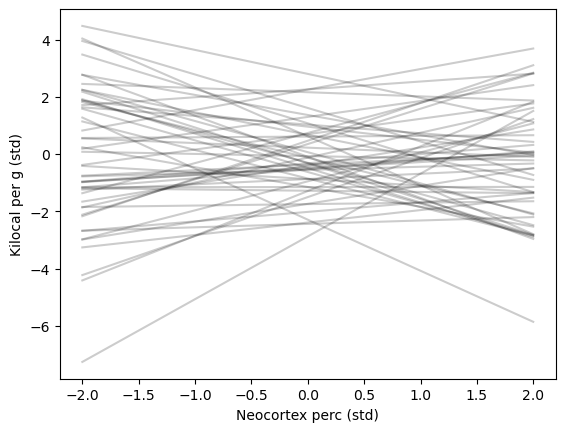

In [21]:
# Media de energía a través de chain
prior_pred_energy = prior_samples_brain.prior_predictive["energy_std"].mean(dim=["chain"])
# Simulamos las primeras 50
fig, ax = plt.subplots()
for i in range(50):
    ax.plot(xseq, prior_pred_energy[i], 'k', alpha=0.2)
ax.set_xlabel("Neocortex perc (std)")
ax.set_ylabel("Kilocal per g (std)")

Más de dos desviaciones estándar es mucha variación. Bajemos un poco la varianza de las previas:

In [29]:
# Shared brain
brain_shared = shared(milk_data["brain_std"].values)
# Modelo
with pm.Model() as brain_model:
    a = pm.Normal("a", 0, 0.2)
    bn = pm.Normal("bn", 0, 0.4)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a + bn * brain_shared
    )
    energy = pm.Normal(
        "energy_std",
        mu,
        sigma,
        observed=milk_data["energy_std"],
        shape=mu.shape
    )

    idata_brain = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bn, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [30]:
# Valores de -2 a 2 desviaciones estándar para el tamaño del cerebro
xseq = [-2, 2]
brain_shared.set_value(np.array(xseq))
# Simulación previa predictiva
with brain_model:
    prior_samples_brain = pm.sample_prior_predictive()

Sampling: [a, bn, energy_std, sigma]


Text(0, 0.5, 'Kilocal per g (std)')

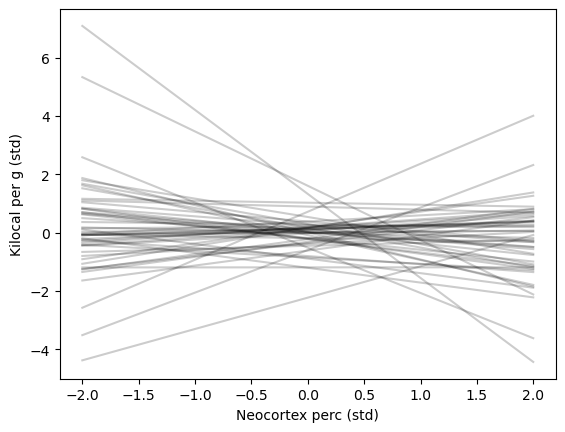

In [31]:
# Media de energía a través de chain
prior_pred_energy = prior_samples_brain.prior_predictive["energy_std"].mean(dim=["chain"])
# Simulamos las primeras 50
fig, ax = plt.subplots()
for i in range(50):
    ax.plot(xseq, prior_pred_energy[i], 'k', alpha=0.2)
ax.set_xlabel("Neocortex perc (std)")
ax.set_ylabel("Kilocal per g (std)")

La mayoría de las líneas están ahora en $\pm 2$ desviaciones estándar.

Revisemos la posterior:

In [33]:
# Summary
az.summary(
    idata_brain,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bn", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.039,0.161,-0.215,0.296
bn,0.111,0.227,-0.219,0.507
sigma,1.108,0.200,0.804,1.397


Como podemos observar en $\beta_N$, la relación entre estas dos variables no es especialmente fuerte. Podemos ver la predicción:

In [34]:
# 30 valores de min a max para el tamaño del cerebro
xseq = np.linspace(milk_data["brain_std"].min(), milk_data["brain_std"].max(), 30)
brain_shared.set_value(xseq)
# Simulamos la posterior predictiva
with brain_model:
    posterior_predictive = pm.sample_posterior_predictive(
        idata_brain,
        var_names=["mu"]
    )

Sampling: []


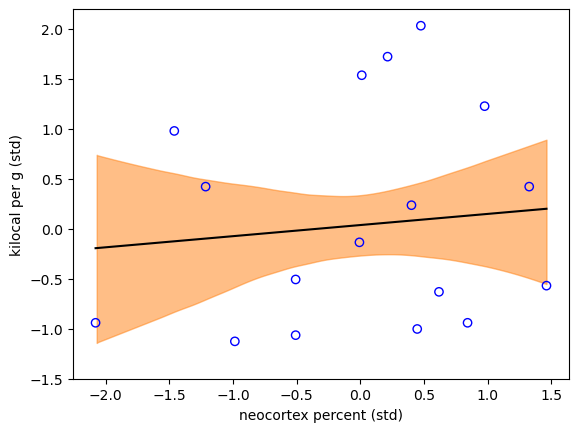

In [35]:
# Posterior predictiva para mu
mu_ppd = posterior_predictive.posterior_predictive["mu"]
# Media a través de chain y draw
mu_mean = mu_ppd.mean(dim=["chain", "draw"])
# Gráfico
fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(milk_data["brain_std"], milk_data["energy_std"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

Similarmente, podemos replicar el modelo con la masa:

In [36]:
# Shared log_mass
log_mass_shared = shared(milk_data["log_mass_std"].values)
# Modelo
with pm.Model() as mass_model:
    a = pm.Normal("a", 0, 0.2)
    bm = pm.Normal("bm", 0, 0.4)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a + bm * log_mass_shared
    )
    energy = pm.Normal(
        "energy_std",
        mu,
        sigma,
        observed=milk_data["energy_std"],
        shape=mu.shape
    )

    idata_mass = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bm, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [37]:
# Summary
az.summary(
    idata_mass,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "bm", "sigma"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.041,0.155,-0.201,0.291
bm,-0.247,0.203,-0.564,0.079
sigma,1.060,0.192,0.759,1.333


In [38]:
# 30 valores de min a max para el tamaño del cerebro
xseq = np.linspace(milk_data["log_mass_std"].min(), milk_data["log_mass_std"].max(), 30)
log_mass_shared.set_value(xseq)
# Posterior predictiva
with mass_model:
    posterior_predictive = pm.sample_posterior_predictive(
        idata_mass,
        var_names=["mu"]
    )

Sampling: []


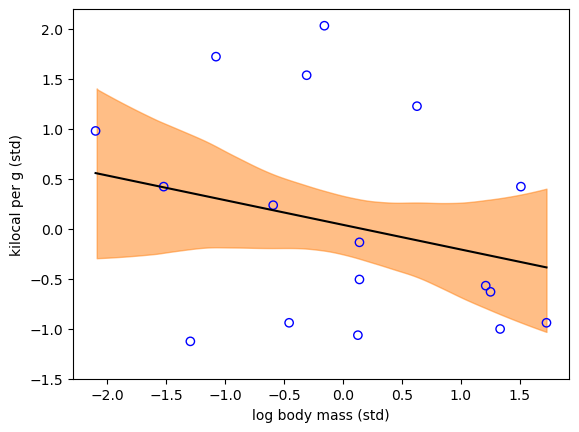

In [39]:
# Posterior predictiva para mu
mu_ppd = posterior_predictive.posterior_predictive["mu"]
# Media a través de chain y draw
mu_mean = mu_ppd.mean(dim=["chain", "draw"])
# Gráficos
fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(milk_data["log_mass_std"], milk_data["energy_std"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");

Observamos que la masa está negativamente asociada con la energía, y de una manera más fuerte que el tamaño del cerebro. Aún así, hay bastante incertidumbre, y asociaciones débiles son consistentes con el intervalo de compatibilidad.

Ahora, veamos qué sucede con un modelo que considera ambos predictores:

$$
\begin{align}
\begin{array}{lcl}
K_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta_N N_i + \beta_M M_i\\
\alpha & \sim & \text{Normal}(0, 0.2) \\
\beta_N & \sim & \text{Normal}(0, 0.5) \\
\beta_M & \sim & \text{Normal}(0, 0.5) \\
\sigma & \sim & \text{Exponential}(1)
\end{array}
\end{align}
$$

In [40]:
# Shared brain
brain_shared = shared(milk_data["brain_std"].values)
# Shared log_mass
log_mass_shared = shared(milk_data["log_mass_std"].values)
# Modelo
with pm.Model() as multivariate_model:
    a = pm.Normal("a", 0, 0.2)
    bm = pm.Normal("bm", 0, 0.4)
    bn = pm.Normal("bn", 0, 0.4)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a + bm * log_mass_shared + bn * brain_shared
    )
    energy = pm.Normal(
        "energy_std",
        mu,
        sigma,
        observed=milk_data["energy_std"],
        shape=mu.shape
    )

    idata_multivariate = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bm, bn, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [41]:
# Summary
az.summary(
    idata_multivariate,
    var_names=["a", "bn", "bm", "sigma"],
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.055,0.145,-0.187,0.275
bn,0.471,0.259,0.070,0.886
bm,-0.517,0.239,-0.883,-0.130
sigma,0.901,0.191,0.610,1.174


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

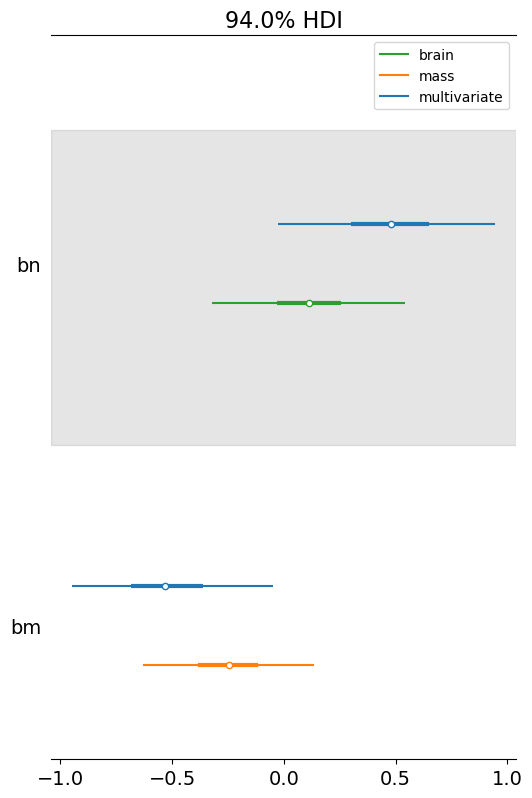

In [42]:
# Plot forest
az.plot_forest(
    [idata_multivariate, idata_mass, idata_brain],
    model_names=["multivariate", "mass", "brain"],
    var_names=["bn", "bm"],
    combined=True
)

**¿Qué pasó acá?**

Cuando consideramos los modelos bivariados para cada una de las variables, vimos que las asociaciones entre el tamaño del cerebro y la energía en la leche era muy débil, al igual que entre la masa corporal y la energía en la leche.

Sin embargo, al considerar el modelo multivariado, las asociaciones evidenciaron ser significativamente más fuertes.

Esto se da porque cada uno de los predictores están asociados con el resultado en formas contrarias, y los predictores entre si están correlacionados de forma positiva.

In [43]:
# Matriz de correlación
milk_data[[
    "kcal_per_g",
    "neocortex_perc",
    "mass"
]].corr()

,kcal_per_g,neocortex_perc,mass
kcal_per_g,1.000000,0.155458,-0.359630
neocortex_perc,0.155458,1.000000,0.614892
mass,-0.359630,0.614892,1.000000


De forma más intuitiva, especies más grandes (con más masa) tienen leche con menos contenido energético. Sin embargo, especies con una neocorteza más grande tienen leche con más contenido en ergético. Pero la masa corporal y el tamaño de la neocorteza también están relacionados, lo que hace complejo observar las relacionas anteriormente descritas.

Para finalizar hagamos un par de gráficos contrafactuales nuevamente.

Primero, consideremos como afectan los cambios en la masa, teniendo un tamaño de neocorteza promedio. Recordemos que estas experimentaciones no son posibles en "la vida real", dado que  si cambiamos la masa, el tamaño de la neocorteza cambiaría de manera acorde. En nuestro caso, podemos hacerlo para ver "qué piensa el modelo multivariable" ante solo variaciones de uno de los predictores.

Sampling: []


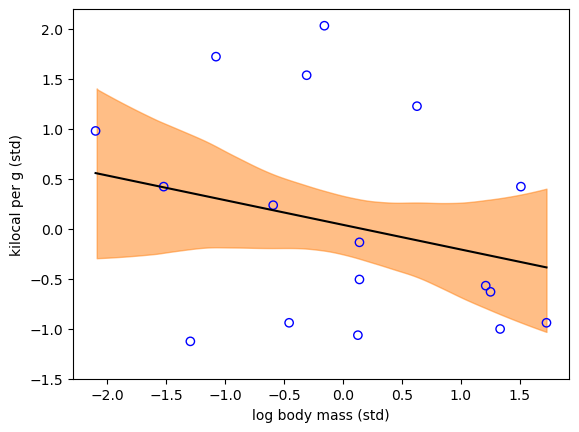

In [45]:
# 30 valores de min a max para el tamaño del cerebro
xseq = np.linspace(milk_data["log_mass_std"].min(), milk_data["log_mass_std"].max(), 30)
log_mass_shared.set_value(xseq)
# Posterior predictiva
with mass_model:
    posterior_predictive = pm.sample_posterior_predictive(
        idata_mass,
        var_names=["mu"]
    )
# Posterior predictiva para mu
mu_ppd = posterior_predictive.posterior_predictive["mu"]
# Media a través de chain y draw
mu_mean = mu_ppd.mean(dim=["chain", "draw"])
# Gráficos
fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(milk_data["log_mass_std"], milk_data["energy_std"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");

Sampling: []


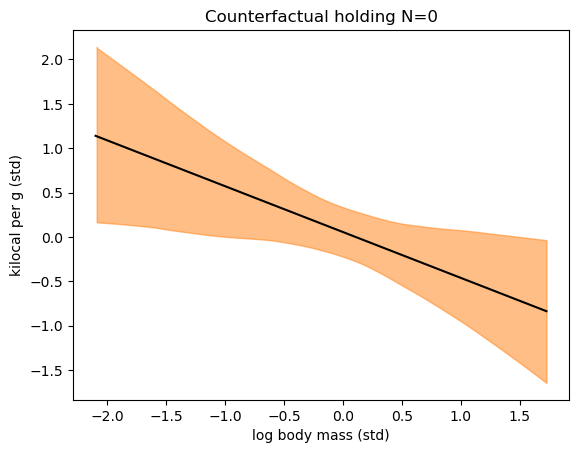

In [47]:
# 30 valores de min a max para la masa
xseq = np.linspace(milk_data["log_mass_std"].min(), milk_data["log_mass_std"].max(), 30)
log_mass_shared.set_value(xseq)
# Tamaño de cerebro promedio
brain_shared.set_value(np.zeros(30))
# Posterior predictiva
with multivariate_model:
    posterior_predictive = pm.sample_posterior_predictive(
        idata_multivariate,
        var_names=["mu"]
    )
# Posterior predictiva para mu
mu_ppd = posterior_predictive.posterior_predictive["mu"]
# Media a través de chain y draw
mu_mean = mu_ppd.mean(dim=["chain", "draw"])
# Gráfico
fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

Ahora, hagamos lo mismo para el tamaño de la neocorteza:

Sampling: []


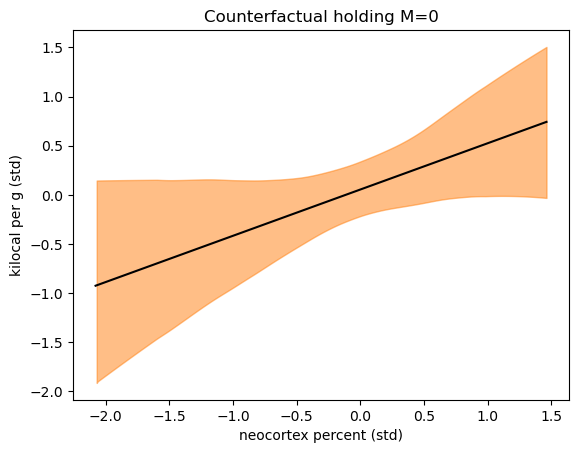

In [49]:
# 30 valores de min a max para el cerebro
xseq = np.linspace(milk_data["brain_std"].min(), milk_data["brain_std"].max(), 30)
brain_shared.set_value(xseq)
# Masa promedio
log_mass_shared.set_value(np.zeros(30))
# Posterior predictiva
with multivariate_model:
    posterior_predictive = pm.sample_posterior_predictive(
        idata_multivariate,
        var_names=["mu"]
    )
# Posterior predictiva para mu
mu_ppd = posterior_predictive.posterior_predictive["mu"]
# Media a través de chain y draw
mu_mean = mu_ppd.mean(dim=["chain", "draw"])
# Gráfico
fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_title("Counterfactual holding M=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("neocortex percent (std)");

Una vez más, vemos como los gráficos contrafactuales nos demuestran que la influencia de cada predictor en un modelo considerando ambos es bastante más fuerte, que considerando modelos bivariados simples.

**Nota.**

Una de las técnicas más comunes de selección de características es descartar predictores con alta correlación. ¿Ven por qué esto puede ser bastante nocivo?